<a href="https://colab.research.google.com/github/ajitonelsonn/H_ArngoDB/blob/main/STEPS_MedGraph_Navigator_Patient_Journey_%26_Risk_Analytics_Platform.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Step 0: Package Installation & Setup

In [1]:
# 1. Install nx-arangodb
!pip install nx-arangodb

# 2. Install nx-cugraph (if GPU available)
!pip install cudf-cu12 cugraph-cu12 --extra-index-url https://pypi.nvidia.com


# 3. Install LangChain & LangGraph
!pip install --upgrade langchain langchain-community langchain-openai langgraph langchain-together

# 4. Install Together AI and Gradio
!pip install together gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 66.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 77.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.5/116.5 kB 13.9 MB/s eta 0:00:00
  Attempting uninstall: networkx
    Found existing installation: networkx 3.4.2
    Uninstalling networkx-3.4.2:
      Successfully uninstalled networkx-3.4.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.5.1+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-cupti-cu12 12.5.82 whic

In [2]:
# 2. Check for NVIDIA GPU
!nvidia-smi
!nvcc --version

Thu Feb 20 05:38:58 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   48C    P8             12W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [3]:
# 6. Import all required modules
import networkx as nx
import nx_arangodb as nxadb
from arango import ArangoClient

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import os
import requests
import pickle
from zipfile import ZipFile
from io import BytesIO
import re
import seaborn as sns

from collections import defaultdict

# AI and Graph Components
from together import Together
from langchain_core.tools import tool
from langgraph.prebuilt import create_react_agent
from langchain_community.graphs import ArangoGraph
from langchain_community.chains.graph_qa.arangodb import ArangoGraphQAChain

# 7. Configure ArangoDB Cloud connection
ARANGODB_URL = "https://xxxxx.arangodb.cloud:8529"
ARANGODB_USER = "xxxx"
ARANGODB_PASSWORD = "xxxx"


# Initialize ArangoDB client
client = ArangoClient(hosts=ARANGODB_URL)
db = client.db( username=ARANGODB_USER, password=ARANGODB_PASSWORD, verify=True)

# Test connection
try:
    print("ArangoDB version:", db.version())
    print("Connection successful!")
except Exception as e:
    print("Connection failed:", str(e))

# 8. Configure Together AI
os.environ["TOGETHER_API_KEY"] = "xxxxxx"
together_client = Together()

# Print setup completion
print("\nInitial setup complete!")
print("- ArangoDB: Connected")
print("- Together AI: Configured")
print("- Required packages: Installed")

[05:40:43 +0000] [INFO]: NetworkX-cuGraph is available.
INFO:nx_arangodb:NetworkX-cuGraph is available.


ArangoDB version: 3.12.4
Connection successful!

Initial setup complete!
- ArangoDB: Connected
- Together AI: Configured
- Required packages: Installed


## Step 1: Choose & Prepare Dataset for NetworkX

In this section, we will:
1. Download and extract the Synthea medical dataset
2. Load and analyze core CSV files
3. Prepare data structures for graph construction
4. Validate data quality

In [4]:
# [Code Cell 1] - Download Synthea Dataset
print("Downloading Synthea dataset...")

def download_synthea():
    """Downloads and extracts Synthea medical dataset"""
    url = "https://huggingface.co/datasets/ajitonelson/synthetic-mass-health-data/resolve/main/SyntheticMass_Data_Hack_ArangoDB.zip"
    try:
        response = requests.get(url)
        with ZipFile(BytesIO(response.content)) as zip_file:
            os.makedirs('synthea_data', exist_ok=True)
            zip_file.extractall('synthea_data')
            print("\nFiles extracted to 'synthea_data' directory:")
            for file in zip_file.namelist():
                print(f"- {file}")
    except Exception as e:
        print("Download failed:", str(e))

# Execute download
download_synthea()


Files extracted to 'synthea_data' directory:
- supplies.csv
- allergies.csv
- procedures.csv
- claims_transactions.csv
- medications.csv
- payers.csv
- claims.csv
- observations.csv
- encounters.csv
- patients.csv
- immunizations.csv
- conditions.csv
- providers.csv
- imaging_studies.csv
- devices.csv
- careplans.csv
- organizations.csv
- payer_transitions.csv


In [5]:
# [Code Cell 2] - Define Core Medical Files
CORE_FILES = {
    # Patient core data
    'patients': 'synthea_data/patients.csv',
    'encounters': 'synthea_data/encounters.csv',
    'conditions': 'synthea_data/conditions.csv',
    'medications': 'synthea_data/medications.csv',
    'procedures': 'synthea_data/procedures.csv',
    'providers': 'synthea_data/providers.csv',
    'organizations': 'synthea_data/organizations.csv',

    # Risk and journey analysis data
    'observations': 'synthea_data/observations.csv',
    'allergies': 'synthea_data/allergies.csv',
    'immunizations': 'synthea_data/immunizations.csv',
    'careplans': 'synthea_data/careplans.csv',
    'imaging_studies': 'synthea_data/imaging_studies.csv'
}

print("\nCore medical files defined:")
core_items = list(CORE_FILES.items())  # Convert dict_items to a list
for category, files in {
    "Patient Core Data": core_items[:7],
    "Risk & Journey Analysis Data": core_items[7:]
}.items():
    print(f"\n{category}:")
    for name, path in files:
        print(f"- {name}: {path}")


Core medical files defined:

Patient Core Data:
- patients: synthea_data/patients.csv
- encounters: synthea_data/encounters.csv
- conditions: synthea_data/conditions.csv
- medications: synthea_data/medications.csv
- procedures: synthea_data/procedures.csv
- providers: synthea_data/providers.csv
- organizations: synthea_data/organizations.csv

Risk & Journey Analysis Data:
- observations: synthea_data/observations.csv
- allergies: synthea_data/allergies.csv
- immunizations: synthea_data/immunizations.csv
- careplans: synthea_data/careplans.csv
- imaging_studies: synthea_data/imaging_studies.csv


In [6]:
# [Code Cell 3] - Basic Data Analysis Function
def analyze_csv(filepath):
    """Analyze structure and content of CSV file"""
    df = pd.read_csv(filepath)
    print(f"\nAnalyzing {os.path.basename(filepath)}")
    print("-" * 50)

    # Basic statistics
    print(f"Shape: {df.shape}")
    print(f"Memory usage: {df.memory_usage().sum() / 1024:.2f} KB")

    # Column analysis
    print("\nColumns:")
    for col in df.columns:
        non_null = df[col].count()
        null_count = df[col].isnull().sum()
        dtype = df[col].dtype
        unique_count = df[col].nunique()
        print(f"- {col}:")
        print(f"  * Type: {dtype}")
        print(f"  * Non-null: {non_null}")
        print(f"  * Null: {null_count}")
        print(f"  * Unique values: {unique_count}")

        # Show sample values for categorical columns
        if dtype == 'object' and unique_count < 10:
            sample_values = df[col].unique()[:5]
            print(f"  * Sample values: {', '.join(str(x) for x in sample_values)}")

    # Additional dataset-specific analysis
    if 'START' in df.columns:
        df['START'] = pd.to_datetime(df['START'])
        print(f"\nDate range: {df['START'].min()} to {df['START'].max()}")

    return df

# [Code Cell 4] - Load and Analyze Datasets
print("Loading and analyzing datasets...")
dataframes = {}
for name, filepath in CORE_FILES.items():
    dataframes[name] = analyze_csv(filepath)

Loading and analyzing datasets...

Analyzing patients.csv
--------------------------------------------------
Shape: (106, 28)
Memory usage: 23.32 KB

Columns:
- Id:
  * Type: object
  * Non-null: 106
  * Null: 0
  * Unique values: 106
- BIRTHDATE:
  * Type: object
  * Non-null: 106
  * Null: 0
  * Unique values: 100
- DEATHDATE:
  * Type: object
  * Non-null: 6
  * Null: 100
  * Unique values: 6
  * Sample values: nan, 2009-12-11, 2017-06-07, 1972-06-01, 2011-01-28
- SSN:
  * Type: object
  * Non-null: 106
  * Null: 0
  * Unique values: 106
- DRIVERS:
  * Type: object
  * Non-null: 84
  * Null: 22
  * Unique values: 84
- PASSPORT:
  * Type: object
  * Non-null: 75
  * Null: 31
  * Unique values: 75
- PREFIX:
  * Type: object
  * Non-null: 79
  * Null: 27
  * Unique values: 3
  * Sample values: Mr., nan, Mrs., Ms.
- FIRST:
  * Type: object
  * Non-null: 106
  * Null: 0
  * Unique values: 104
- MIDDLE:
  * Type: object
  * Non-null: 89
  * Null: 17
  * Unique values: 88
- LAST:
  * Type:

In [7]:
# [Code Cell 5] - Patient Journey Analysis
print("\nAnalyzing Patient Journeys and Relationships")
print("-" * 50)

# Basic statistics
patient_stats = {
    'total_patients': len(dataframes['patients']),
    'with_encounters': len(dataframes['encounters']['PATIENT'].unique()),
    'with_conditions': len(dataframes['conditions']['PATIENT'].unique()),
    'with_medications': len(dataframes['medications']['PATIENT'].unique()),
    'with_observations': len(dataframes['observations']['PATIENT'].unique()),
    'with_allergies': len(dataframes['allergies']['PATIENT'].unique()),
    'with_immunizations': len(dataframes['immunizations']['PATIENT'].unique()),
    'with_imaging': len(dataframes['imaging_studies']['PATIENT'].unique())
}

print("\nPatient Journey Statistics:")
for key, value in patient_stats.items():
    print(f"- {key}: {value}")

# Encounter relationships
encounter_stats = {
    'total_encounters': len(dataframes['encounters']),
    'with_conditions': len(dataframes['conditions']['ENCOUNTER'].unique()),
    'with_medications': len(dataframes['medications']['ENCOUNTER'].unique()),
    'with_procedures': len(dataframes['procedures']['ENCOUNTER'].unique()),
    'with_observations': len(dataframes['observations']['ENCOUNTER'].unique()),
    'with_imaging': len(dataframes['imaging_studies']['ENCOUNTER'].unique())
}

print("\nEncounter Statistics:")
for key, value in encounter_stats.items():
    print(f"- {key}: {value}")


Analyzing Patient Journeys and Relationships
--------------------------------------------------

Patient Journey Statistics:
- total_patients: 106
- with_encounters: 106
- with_conditions: 106
- with_medications: 105
- with_observations: 106
- with_allergies: 15
- with_immunizations: 106
- with_imaging: 93

Encounter Statistics:
- total_encounters: 7049
- with_conditions: 2542
- with_medications: 2578
- with_procedures: 5269
- with_observations: 4073
- with_imaging: 397


In [8]:
# [Code Cell 6] - Risk Factor Analysis
print("\nAnalyzing Risk Factors")
print("-" * 50)

def analyze_risk_factors(dataframes):
    risk_factors = {
        'allergies': {
            'total': len(dataframes['allergies']),
            'unique_types': dataframes['allergies']['TYPE'].nunique(),
            'severity_distribution': dataframes['allergies']['SEVERITY1'].value_counts().to_dict()
        },
        'observations': {
            'total': len(dataframes['observations']),
            'unique_categories': dataframes['observations']['CATEGORY'].nunique(),
            'vital_signs': len(dataframes['observations'][
                dataframes['observations']['CATEGORY'] == 'vital-signs'
            ])
        },
        'conditions': {
            'total': len(dataframes['conditions']),
            'active_conditions': len(dataframes['conditions'][
                dataframes['conditions']['STOP'].isna()
            ])
        }
    }

    print("\nRisk Factor Statistics:")
    for category, stats in risk_factors.items():
        print(f"\n{category.capitalize()}:")
        for key, value in stats.items():
            print(f"- {key}: {value}")

    return risk_factors

risk_analysis = analyze_risk_factors(dataframes)


Analyzing Risk Factors
--------------------------------------------------

Risk Factor Statistics:

Allergies:
- total: 92
- unique_types: 1
- severity_distribution: {'MODERATE': 26, 'SEVERE': 10, 'MILD': 8}

Observations:
- total: 86360
- unique_categories: 8
- vital_signs: 16989

Conditions:
- total: 3876
- active_conditions: 891


In [9]:
# [Code Cell 7] - Care Plan Analysis
print("\nAnalyzing Care Plans and Treatments")
print("-" * 50)

def analyze_care_plans(dataframes):
    care_stats = {
        'careplans': {
            'total': len(dataframes['careplans']),
            'active_plans': len(dataframes['careplans'][
                dataframes['careplans']['STOP'].isna()
            ]),
            'unique_reasons': dataframes['careplans']['REASONDESCRIPTION'].nunique()
        },
        'medications': {
            'total': len(dataframes['medications']),
            'unique_medications': dataframes['medications']['DESCRIPTION'].nunique(),
            'average_cost': dataframes['medications']['BASE_COST'].mean()
        },
        'procedures': {
            'total': len(dataframes['procedures']),
            'unique_procedures': dataframes['procedures']['DESCRIPTION'].nunique(),
            'average_cost': dataframes['procedures']['BASE_COST'].mean()
        }
    }

    print("\nCare Plan Statistics:")
    for category, stats in care_stats.items():
        print(f"\n{category.capitalize()}:")
        for key, value in stats.items():
            if 'cost' in key:
                print(f"- {key}: ${value:.2f}")
            else:
                print(f"- {key}: {value}")

    return care_stats

care_analysis = analyze_care_plans(dataframes)


Analyzing Care Plans and Treatments
--------------------------------------------------

Care Plan Statistics:

Careplans:
- total: 329
- active_plans: 154
- unique_reasons: 35

Medications:
- total: 5605
- unique_medications: 121
- average_cost: $143.61

Procedures:
- total: 17784
- unique_procedures: 225
- average_cost: $879.01



Creating Patient Journey Visualizations
--------------------------------------------------


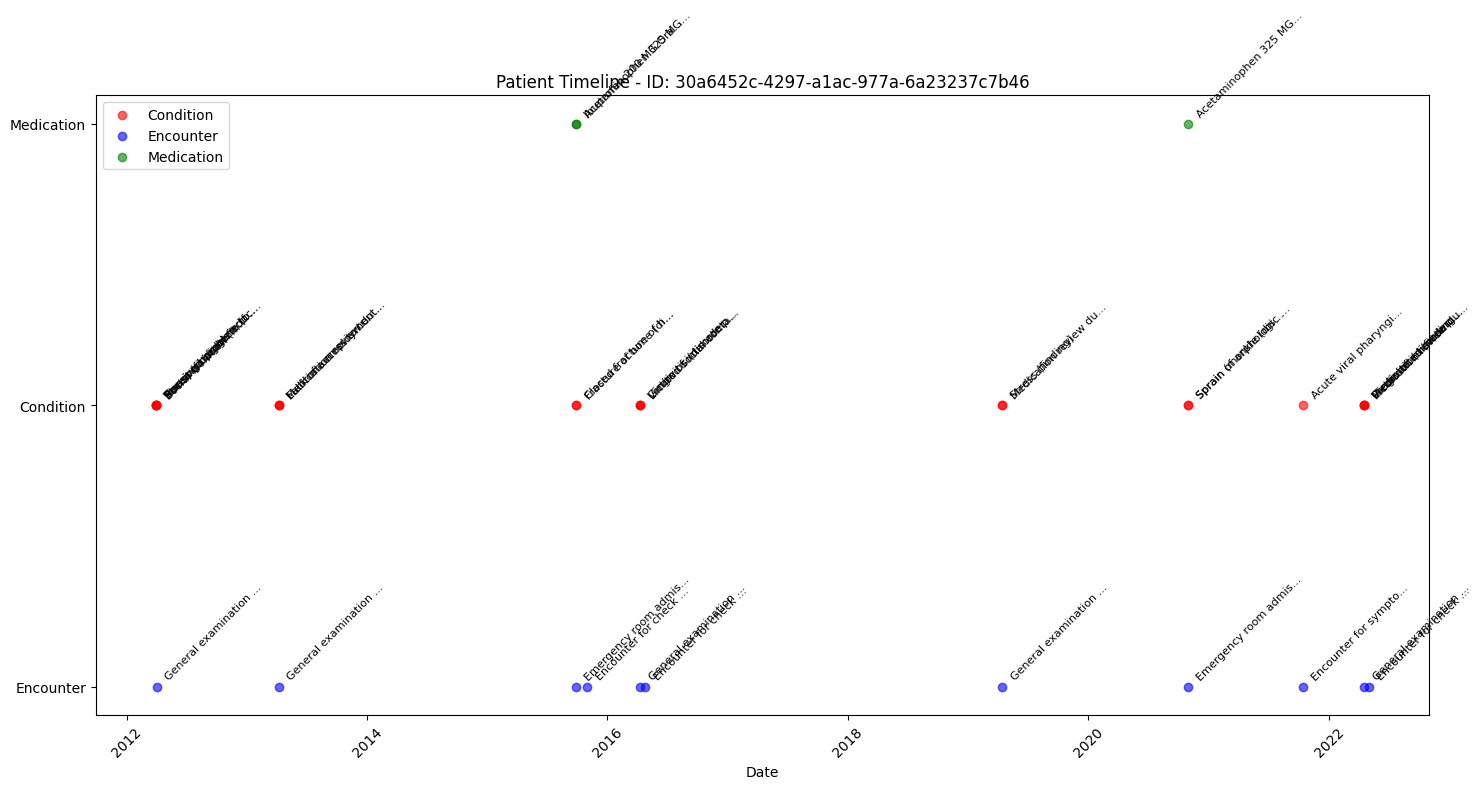

Successfully created timeline with 36 events for patient 30a6452c-4297-a1ac-977a-6a23237c7b46

Timeline Summary:
Events by type:
type
Condition     22
Encounter     11
Medication     3
Name: count, dtype: int64

Date range:
Start: 2012-04-01 00:00:00
End: 2022-05-01 09:04:48


In [10]:
# [Code Cell 8] - Patient Timeline Visualization
print("\nCreating Patient Journey Visualizations")
print("-" * 50)

# Create directory if it doesn't exist
os.makedirs('processed_data', exist_ok=True)

def visualize_patient_timeline(dataframes, patient_id=None):
    """Create timeline visualization for a patient's medical journey"""
    try:
        if patient_id is None:
            # Get first patient ID if none specified
            patient_id = dataframes['patients']['Id'].iloc[0]

        # Collect all events for the patient
        events = []

        # Encounters
        encounters = dataframes['encounters'][dataframes['encounters']['PATIENT'] == patient_id]
        if not encounters.empty:
            for _, row in encounters.iterrows():
                try:
                    # Convert to timezone-naive datetime with error handling
                    date = pd.to_datetime(row['START'])
                    if pd.notnull(date):
                        date = date.tz_localize(None)
                        events.append({
                            'date': date,
                            'type': 'Encounter',
                            'description': row['DESCRIPTION']
                        })
                except Exception as e:
                    print(f"Error processing encounter: {str(e)}")
                    continue

        # Conditions
        conditions = dataframes['conditions'][dataframes['conditions']['PATIENT'] == patient_id]
        if not conditions.empty:
            for _, row in conditions.iterrows():
                try:
                    # Convert to timezone-naive datetime with error handling
                    date = pd.to_datetime(row['START'])
                    if pd.notnull(date):
                        date = date.tz_localize(None)
                        events.append({
                            'date': date,
                            'type': 'Condition',
                            'description': row['DESCRIPTION']
                        })
                except Exception as e:
                    print(f"Error processing condition: {str(e)}")
                    continue

        # Medications
        medications = dataframes['medications'][dataframes['medications']['PATIENT'] == patient_id]
        if not medications.empty:
            for _, row in medications.iterrows():
                try:
                    # Convert to timezone-naive datetime with error handling
                    date = pd.to_datetime(row['START'])
                    if pd.notnull(date):
                        date = date.tz_localize(None)
                        events.append({
                            'date': date,
                            'type': 'Medication',
                            'description': row['DESCRIPTION']
                        })
                except Exception as e:
                    print(f"Error processing medication: {str(e)}")
                    continue

        # Convert to DataFrame and sort
        events_df = pd.DataFrame(events)
        if len(events_df) == 0:
            print(f"No valid events found for patient {patient_id}")
            return None

        events_df = events_df.sort_values('date')

        # Create visualization
        plt.figure(figsize=(15, 8))

        # Plot different event types
        colors = {'Encounter': 'blue', 'Condition': 'red', 'Medication': 'green'}
        y_positions = {event_type: i for i, event_type in enumerate(colors.keys())}

        for event_type, group in events_df.groupby('type'):
            plt.scatter(group['date'],
                       [y_positions[event_type]] * len(group),
                       label=event_type,
                       c=colors[event_type],
                       alpha=0.6)

            # Add event descriptions as annotations with error handling
            for _, row in group.iterrows():
                try:
                    description = row['description']
                    if pd.notnull(description):
                        description = str(description)
                        truncated_desc = description[:20] + '...' if len(description) > 20 else description
                        plt.annotate(truncated_desc,
                                    (row['date'], y_positions[event_type]),
                                    xytext=(5, 5), textcoords='offset points',
                                    fontsize=8, rotation=45)
                except Exception as e:
                    print(f"Error adding annotation: {str(e)}")
                    continue

        plt.yticks(list(y_positions.values()), list(y_positions.keys()))
        plt.title(f'Patient Timeline - ID: {patient_id}')
        plt.xlabel('Date')
        plt.xticks(rotation=45)
        plt.legend()

        plt.tight_layout()
        plt.savefig(f'processed_data/patient_timeline_{patient_id}.png')
        plt.show()
        plt.close()

        print(f"Successfully created timeline with {len(events_df)} events for patient {patient_id}")
        return events_df

    except Exception as e:
        print(f"Error creating timeline: {str(e)}")
        plt.close()  # Ensure figure is closed even if error occurs
        return None

# Create sample timeline and display summary
try:
    sample_timeline = visualize_patient_timeline(dataframes)
    if sample_timeline is not None:
        print("\nTimeline Summary:")
        print("Events by type:")
        print(sample_timeline['type'].value_counts())
        print("\nDate range:")
        print(f"Start: {sample_timeline['date'].min()}")
        print(f"End: {sample_timeline['date'].max()}")
except Exception as e:
    print(f"Error in timeline creation and summary: {str(e)}")


Visualizing Risk Patterns
--------------------------------------------------


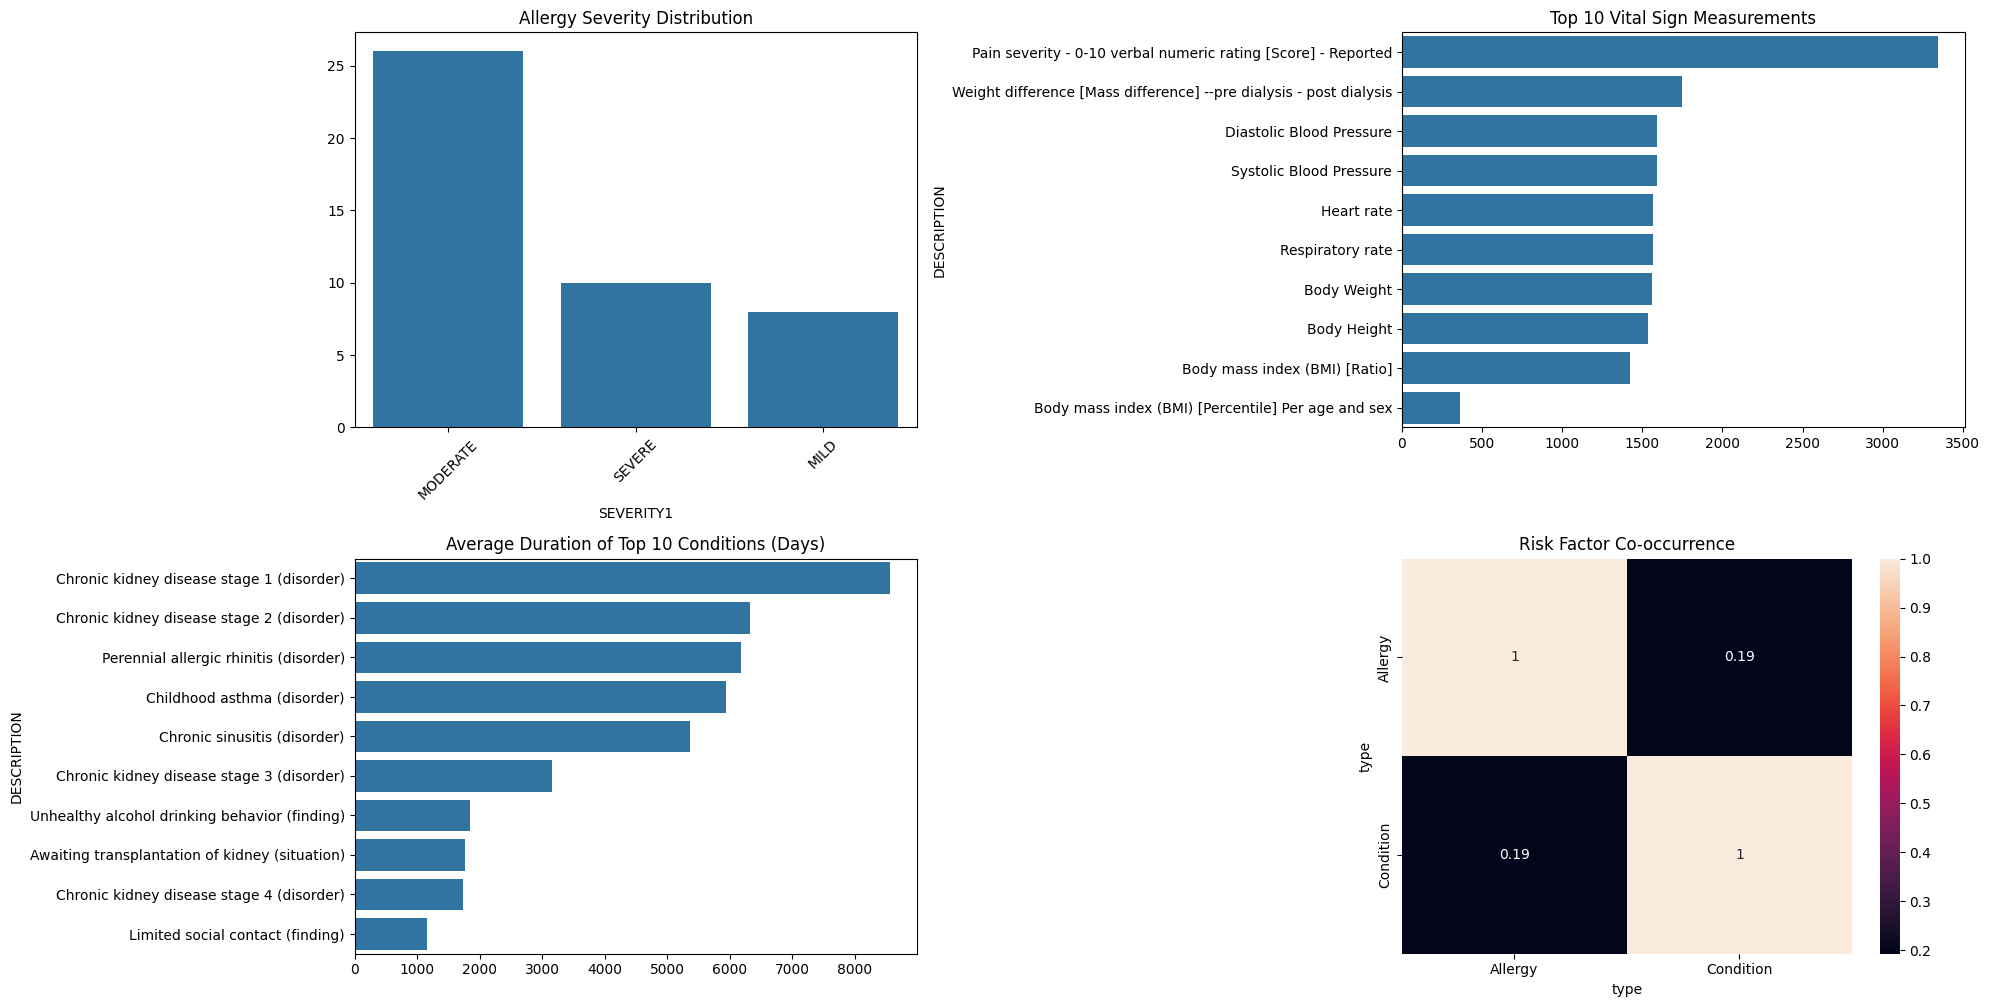

Risk pattern visualizations saved successfully

Risk Analysis Summary:

allergy_severity:
SEVERITY1
MODERATE    26
SEVERE      10
MILD         8
Name: count, dtype: int64

vital_types:
DESCRIPTION
Pain severity - 0-10 verbal numeric rating [Score] - Reported         3343
Weight difference [Mass difference] --pre dialysis - post dialysis    1745
Diastolic Blood Pressure                                              1593
Systolic Blood Pressure                                               1593
Heart rate                                                            1568
Name: count, dtype: int64

condition_duration:
DESCRIPTION
Chronic kidney disease stage 1 (disorder)    8570.333333
Chronic kidney disease stage 2 (disorder)    6321.000000
Perennial allergic rhinitis (disorder)       6179.000000
Childhood asthma (disorder)                  5940.000000
Chronic sinusitis (disorder)                 5372.000000
Name: duration, dtype: float64

risk_correlation:
type        Allergy  Condition
typ

In [11]:
# [Code Cell 9] - Risk Pattern Visualization
print("\nVisualizing Risk Patterns")
print("-" * 50)

# Create directory if it doesn't exist
os.makedirs('processed_data', exist_ok=True)

def visualize_risk_patterns(dataframes):
    """Create visualizations of risk patterns"""
    try:
        plt.figure(figsize=(20, 15))

        # 1. Allergy Risk Distribution
        plt.subplot(3, 2, 1)
        allergy_severity = dataframes['allergies']['SEVERITY1'].value_counts().dropna()
        if not allergy_severity.empty:
            sns.barplot(x=allergy_severity.index, y=allergy_severity.values)
            plt.title('Allergy Severity Distribution')
            plt.xticks(rotation=45)

        # 2. Vital Signs Distribution
        plt.subplot(3, 2, 2)
        vital_signs = dataframes['observations'][
            dataframes['observations']['CATEGORY'] == 'vital-signs'
        ]
        vital_types = vital_signs['DESCRIPTION'].value_counts().head(10)
        if not vital_types.empty:
            sns.barplot(x=vital_types.values, y=vital_types.index)
            plt.title('Top 10 Vital Sign Measurements')

        # 3. Condition Duration Analysis
        plt.subplot(3, 2, 3)
        condition_duration = dataframes['conditions'].copy()
        condition_duration['START'] = pd.to_datetime(condition_duration['START'])
        condition_duration['STOP'] = pd.to_datetime(condition_duration['STOP'])
        condition_duration['duration'] = (condition_duration['STOP'] -
                                        condition_duration['START']).dt.days

        top_conditions = condition_duration.groupby('DESCRIPTION')['duration'].mean()
        top_conditions = top_conditions.sort_values(ascending=False).head(10)
        if not top_conditions.empty:
            sns.barplot(x=top_conditions.values, y=top_conditions.index)
            plt.title('Average Duration of Top 10 Conditions (Days)')

        # 4. Risk Factor Co-occurrence
        plt.subplot(3, 2, 4)
        risk_factors = pd.concat([
            dataframes['conditions'][['PATIENT', 'DESCRIPTION']].assign(type='Condition'),
            dataframes['allergies'][['PATIENT', 'DESCRIPTION']].assign(type='Allergy')
        ])

        if not risk_factors.empty:
            risk_matrix = pd.crosstab(
                risk_factors['PATIENT'],
                risk_factors['type']
            )
            sns.heatmap(risk_matrix.corr(), annot=True)
            plt.title('Risk Factor Co-occurrence')

        plt.tight_layout()
        plt.savefig('processed_data/risk_patterns.png')
        plt.show()
        plt.close()

        print("Risk pattern visualizations saved successfully")

        return {
            'allergy_severity': allergy_severity,
            'vital_types': vital_types,
            'condition_duration': top_conditions,
            'risk_correlation': risk_matrix.corr() if not risk_factors.empty else None
        }

    except Exception as e:
        print(f"Error creating risk visualizations: {str(e)}")
        plt.close()  # Ensure figure is closed even if error occurs
        return None

# Create risk visualizations
risk_visualizations = visualize_risk_patterns(dataframes)

if risk_visualizations:
    print("\nRisk Analysis Summary:")
    for key, value in risk_visualizations.items():
        if value is not None:
            print(f"\n{key}:")
            print(value.head())

# Step 2 - Converting and Loading Graph Data into NetworkX.

In [12]:
# [Code Cell 1] - Prepare Graph Structure
print("Preparing medical graph structure...")

def create_node_id(prefix, id_value):
    """Create standardized node ID"""
    return f"{prefix}/{str(id_value)}"

# Define node and edge schemas
NODE_TYPES = {
    'Patient': ['Id', 'BIRTHDATE', 'GENDER', 'RACE'],
    'Provider': ['Id', 'NAME', 'SPECIALITY', 'ORGANIZATION'],
    'Organization': ['Id', 'NAME', 'CITY', 'STATE'],
    'Encounter': ['Id', 'START', 'STOP', 'ENCOUNTERCLASS'],
    'Condition': ['CODE', 'DESCRIPTION', 'SYSTEM'],
    'Medication': ['CODE', 'DESCRIPTION', 'BASE_COST'],
    'Procedure': ['CODE', 'DESCRIPTION', 'BASE_COST'],
    'Observation': ['CODE', 'DESCRIPTION', 'TYPE', 'CATEGORY'],
    'Allergy': ['CODE', 'DESCRIPTION', 'TYPE', 'SEVERITY1'],
    'CarePlan': ['Id', 'CODE', 'DESCRIPTION']
}

print("Defined node types:")
for node_type, attributes in NODE_TYPES.items():
    print(f"- {node_type}: {', '.join(attributes)}")

Preparing medical graph structure...
Defined node types:
- Patient: Id, BIRTHDATE, GENDER, RACE
- Provider: Id, NAME, SPECIALITY, ORGANIZATION
- Organization: Id, NAME, CITY, STATE
- Encounter: Id, START, STOP, ENCOUNTERCLASS
- Condition: CODE, DESCRIPTION, SYSTEM
- Medication: CODE, DESCRIPTION, BASE_COST
- Procedure: CODE, DESCRIPTION, BASE_COST
- Observation: CODE, DESCRIPTION, TYPE, CATEGORY
- Allergy: CODE, DESCRIPTION, TYPE, SEVERITY1
- CarePlan: Id, CODE, DESCRIPTION


In [13]:
# [Code Cell 2] - Create NetworkX Graph
print("\nCreating NetworkX graph...")

# Create directed graph
G = nx.DiGraph()

def add_nodes_with_attributes(G, df, node_type, id_column='Id', attributes=None):
    """Add nodes to graph with specified attributes"""
    if attributes is None:
        attributes = NODE_TYPES[node_type]

    for _, row in df.iterrows():
        node_id = create_node_id(node_type, row[id_column])
        # Create attribute dictionary
        attr_dict = {
            'type': node_type.lower(),
            **{col: row[col] for col in attributes if col in row}
        }
        G.add_node(node_id, **attr_dict)

# Add nodes for each entity type
print("\nAdding nodes to graph...")
add_nodes_with_attributes(G, dataframes['patients'], 'Patient')
add_nodes_with_attributes(G, dataframes['providers'], 'Provider')
add_nodes_with_attributes(G, dataframes['organizations'], 'Organization')
add_nodes_with_attributes(G, dataframes['encounters'], 'Encounter')
add_nodes_with_attributes(G, dataframes['conditions'], 'Condition', 'CODE')
add_nodes_with_attributes(G, dataframes['medications'], 'Medication', 'CODE')
add_nodes_with_attributes(G, dataframes['procedures'], 'Procedure', 'CODE')
add_nodes_with_attributes(G, dataframes['observations'], 'Observation', 'CODE')
add_nodes_with_attributes(G, dataframes['allergies'], 'Allergy', 'CODE')
add_nodes_with_attributes(G, dataframes['careplans'], 'CarePlan')

print(f"Added {G.number_of_nodes()} nodes to graph")


Creating NetworkX graph...

Adding nodes to graph...
Added 8776 nodes to graph


In [14]:
# [Code Cell 3] - Add Relationships
print("\nAdding relationships to graph...")

def add_relationships(G, df, start_prefix, end_prefix,
                     start_col, end_col, relationship_type):
    """Add edges between nodes with relationship type"""
    count = 0
    for _, row in df.iterrows():
        start_id = create_node_id(start_prefix, row[start_col])
        end_id = create_node_id(end_prefix, row[end_col])
        if start_id in G and end_id in G:
            G.add_edge(start_id, end_id, relationship_type=relationship_type)
            count += 1
    return count

# Add core relationships
relationships = {
    'PATIENT_ENCOUNTER': (dataframes['encounters'], 'Patient', 'Encounter', 'PATIENT', 'Id'),
    'PROVIDER_ORGANIZATION': (dataframes['providers'], 'Provider', 'Organization', 'Id', 'ORGANIZATION'),
    'ENCOUNTER_PROVIDER': (dataframes['encounters'], 'Encounter', 'Provider', 'Id', 'PROVIDER'),
    'ENCOUNTER_CONDITION': (dataframes['conditions'], 'Encounter', 'Condition', 'ENCOUNTER', 'CODE'),
    'ENCOUNTER_MEDICATION': (dataframes['medications'], 'Encounter', 'Medication', 'ENCOUNTER', 'CODE'),
    'ENCOUNTER_PROCEDURE': (dataframes['procedures'], 'Encounter', 'Procedure', 'ENCOUNTER', 'CODE'),
    'ENCOUNTER_OBSERVATION': (dataframes['observations'], 'Encounter', 'Observation', 'ENCOUNTER', 'CODE'),
    'PATIENT_ALLERGY': (dataframes['allergies'], 'Patient', 'Allergy', 'PATIENT', 'CODE'),
    'ENCOUNTER_CAREPLAN': (dataframes['careplans'], 'Encounter', 'CarePlan', 'ENCOUNTER', 'Id')
}

for rel_type, (df, start, end, start_col, end_col) in relationships.items():
    count = add_relationships(G, df, start, end, start_col, end_col, rel_type)
    print(f"Added {count} {rel_type} relationships")

print(f"\nTotal edges in graph: {G.number_of_edges()}")


Adding relationships to graph...
Added 7049 PATIENT_ENCOUNTER relationships
Added 272 PROVIDER_ORGANIZATION relationships
Added 7049 ENCOUNTER_PROVIDER relationships
Added 3876 ENCOUNTER_CONDITION relationships
Added 5605 ENCOUNTER_MEDICATION relationships
Added 17784 ENCOUNTER_PROCEDURE relationships
Added 83198 ENCOUNTER_OBSERVATION relationships
Added 92 PATIENT_ALLERGY relationships
Added 329 ENCOUNTER_CAREPLAN relationships

Total edges in graph: 122201


In [15]:
# [Code Cell 4] - Basic Graph Analysis
print("\nAnalyzing graph structure...")

# Node type distribution
node_types = pd.Series([data['type'] for _, data in G.nodes(data=True)]).value_counts()
print("\nNode type distribution:")
print(node_types)

# Edge type distribution
edge_types = pd.Series([data['relationship_type'] for _, _, data in G.edges(data=True)]).value_counts()
print("\nEdge type distribution:")
print(edge_types)

# Basic network metrics
print("\nNetwork metrics:")
print(f"Average degree: {sum(dict(G.degree()).values())/G.number_of_nodes():.2f}")
print(f"Graph density: {nx.density(G):.4f}")
print(f"Is connected: {nx.is_weakly_connected(G)}")


Analyzing graph structure...

Node type distribution:
encounter       7049
careplan         329
provider         272
organization     272
procedure        225
observation      215
condition        175
medication       116
patient          106
allergy           17
Name: count, dtype: int64

Edge type distribution:
ENCOUNTER_OBSERVATION    81436
ENCOUNTER_PROCEDURE      16549
PATIENT_ENCOUNTER         7049
ENCOUNTER_PROVIDER        7049
ENCOUNTER_MEDICATION      5549
ENCOUNTER_CONDITION       3876
ENCOUNTER_CAREPLAN         329
PROVIDER_ORGANIZATION      272
PATIENT_ALLERGY             92
Name: count, dtype: int64

Network metrics:
Average degree: 27.85
Graph density: 0.0016
Is connected: False


In [16]:
# [Code Cell 5] - Save Graph
print("\nSaving graph...")

# Create directory if it doesn't exist
os.makedirs('processed_data', exist_ok=True)

# Save the graph
with open('processed_data/medical_graph.pickle', 'wb') as f:
    pickle.dump(G, f)

print("Graph saved successfully!")
print(f"- Nodes: {G.number_of_nodes()}")
print(f"- Edges: {G.number_of_edges()}")

# Verify graph can be loaded
with open('processed_data/medical_graph.pickle', 'rb') as f:
    test_graph = pickle.load(f)
print("\nGraph loaded successfully for verification")


Saving graph...
Graph saved successfully!
- Nodes: 8776
- Edges: 122201

Graph loaded successfully for verification


In [17]:
# Debug Code
print("\nGraph Structure Check:")
print(f"Total nodes: {G.number_of_nodes()}")
print(f"Total edges: {G.number_of_edges()}")

# Check edge types
edge_types = defaultdict(int)
for u, v, data in G.edges(data=True):
    edge_types[data.get('relationship_type', 'unknown')] += 1

print("\nEdge type distribution:")
for edge_type, count in edge_types.items():
    print(f"- {edge_type}: {count}")

# Check a sample provider
sample_provider = [n for n, d in G.nodes(data=True) if d['type'] == 'provider'][0]
print(f"\nSample Provider Check ({G.nodes[sample_provider].get('NAME', 'Unknown')}):")
print("Direct neighbors:", list(G.neighbors(sample_provider)))
print("Predecessor nodes:", list(G.predecessors(sample_provider)))
print("Successor nodes:", list(G.successors(sample_provider)))

# Check provider-encounter connections
print("\nProvider-Encounter Relationship Check:")
encounter_provider_edges = [(u, v) for u, v, d in G.edges(data=True)
                          if d.get('relationship_type') == 'ENCOUNTER_PROVIDER']
print(f"Provider-Encounter edges: {len(encounter_provider_edges)}")
if encounter_provider_edges:
    sample_edge = encounter_provider_edges[0]
    print(f"Sample edge: {sample_edge}")
    print(f"Source node type: {G.nodes[sample_edge[0]].get('type')}")
    print(f"Target node type: {G.nodes[sample_edge[1]].get('type')}")


Graph Structure Check:
Total nodes: 8776
Total edges: 122201

Edge type distribution:
- PATIENT_ENCOUNTER: 7049
- PATIENT_ALLERGY: 92
- PROVIDER_ORGANIZATION: 272
- ENCOUNTER_PROVIDER: 7049
- ENCOUNTER_CONDITION: 3876
- ENCOUNTER_MEDICATION: 5549
- ENCOUNTER_PROCEDURE: 16549
- ENCOUNTER_CAREPLAN: 329
- ENCOUNTER_OBSERVATION: 81436

Sample Provider Check (Ted955 Reilly981):
Direct neighbors: ['Organization/74ab949d-17ac-3309-83a0-13b4405c66aa']
Predecessor nodes: ['Encounter/f513edde-b6c3-7d7e-a114-9a8809e4d046', 'Encounter/dd42816c-b321-22dd-d1aa-0382245a65ba', 'Encounter/8b5f4105-bc8f-b077-2850-0da4fa03c3fc', 'Encounter/104c6082-f33b-c12f-1d2f-4ec0fa97b547', 'Encounter/de2d4c8b-a44a-448a-bae3-de1a0db84219', 'Encounter/8ad5fa72-fee0-4573-5dc7-f955ff4b5ba9', 'Encounter/aaa05baa-2503-d174-d4d9-4d1bd104065a', 'Encounter/e6d0499a-c5df-410e-ccd4-2da93157b408', 'Encounter/fc7c8ca1-d7a2-27aa-b579-1d3cbc6e9644', 'Encounter/935cc90d-c9e0-f81d-4937-59efcab060bb', 'Encounter/c18a1ad2-1431-33fb-6

In [18]:
# [Code Cell 6] - Advanced Medical Graph Analysis
print("\nPerforming advanced medical graph analysis...")

def analyze_medical_graph(G):
    # 1. Patient Journey Analysis
    print("\nPatient Journey Analysis:")
    patient_nodes = [n for n, d in G.nodes(data=True) if d['type'] == 'patient']
    encounters_per_patient = {}
    conditions_per_patient = {}

    for patient in patient_nodes:
        # Count encounters
        encounters = [n for n in G.neighbors(patient)
                     if G.nodes[n]['type'] == 'encounter']
        encounters_per_patient[patient] = len(encounters)

        # Count conditions via encounters
        conditions = set()
        for enc in encounters:
            conditions.update([n for n in G.neighbors(enc)
                             if G.nodes[n]['type'] == 'condition'])
        conditions_per_patient[patient] = len(conditions)

    print(f"Average encounters per patient: {np.mean(list(encounters_per_patient.values())):.2f}")
    print(f"Average conditions per patient: {np.mean(list(conditions_per_patient.values())):.2f}")

    # 2. Provider Network Analysis
    print("\nProvider Network Analysis:")
    provider_nodes = [n for n, d in G.nodes(data=True) if d['type'] == 'provider']
    provider_metrics = {}

    for provider in provider_nodes:
        # Get all encounters that point to this provider (predecessors)
        encounters = [n for n in G.predecessors(provider) if G.nodes[n]['type'] == 'encounter']

        # Get all patients and related data through encounters
        patients = set()
        conditions = set()
        medications = set()

        for enc in encounters:
            # Get patients who point to encounters
            patients.update([n for n in G.predecessors(enc) if G.nodes[n]['type'] == 'patient'])
            # Get conditions and medications that encounters point to
            conditions.update([n for n in G.successors(enc) if G.nodes[n]['type'] == 'condition'])
            medications.update([n for n in G.successors(enc) if G.nodes[n]['type'] == 'medication'])

        provider_metrics[provider] = {
            'name': G.nodes[provider].get('NAME', provider),
            'patient_count': len(patients),
            'encounter_count': len(encounters),
            'condition_count': len(conditions),
            'medication_count': len(medications),
            'complexity_score': len(encounters) * 0.4 + len(conditions) * 0.3 + len(medications) * 0.3
        }

    # Get top providers based on complexity score
    top_providers = sorted(provider_metrics.items(), key=lambda x: x[1]['complexity_score'], reverse=True)[:5]
    print("Top 5 most active providers:")
    for provider, metrics in top_providers:
        print(f"- {metrics['name']}:")
        print(f"  * Patients: {metrics['patient_count']}")
        print(f"  * Encounters: {metrics['encounter_count']}")
        print(f"  * Conditions: {metrics['condition_count']}")
        print(f"  * Medications: {metrics['medication_count']}")
        print(f"  * Complexity Score: {metrics['complexity_score']:.2f}")

    # 3. Treatment Pattern Analysis
    print("\nTreatment Pattern Analysis:")
    condition_treatment_pairs = {}
    for enc in [n for n, d in G.nodes(data=True) if d['type'] == 'encounter']:
        conditions = [n for n in G.neighbors(enc) if G.nodes[n]['type'] == 'condition']
        medications = [n for n in G.neighbors(enc) if G.nodes[n]['type'] == 'medication']

        for c in conditions:
            for m in medications:
                pair = (G.nodes[c].get('DESCRIPTION', ''), G.nodes[m].get('DESCRIPTION', ''))
                condition_treatment_pairs[pair] = condition_treatment_pairs.get(pair, 0) + 1

    print("Top 5 condition-medication pairs:")
    top_pairs = sorted(condition_treatment_pairs.items(), key=lambda x: x[1], reverse=True)[:5]
    for (cond, med), count in top_pairs:
        print(f"- {cond} → {med}: {count} times")

    # 4. Risk Pattern Detection
    print("\nRisk Pattern Analysis:")
    high_risk_patients = []
    for patient in patient_nodes:
        risk_score = 0
        encounters = [n for n in G.neighbors(patient) if G.nodes[n]['type'] == 'encounter']

        # Count conditions, medications, and procedures
        total_conditions = sum(1 for e in encounters for n in G.neighbors(e)
                             if G.nodes[n]['type'] == 'condition')
        total_medications = sum(1 for e in encounters for n in G.neighbors(e)
                              if G.nodes[n]['type'] == 'medication')

        risk_score = total_conditions * 0.4 + total_medications * 0.3
        if risk_score > np.mean([p[1] for p in high_risk_patients] or [0]):
            high_risk_patients.append((patient, risk_score))

    print("Identified high-risk patients:")
    for patient, score in sorted(high_risk_patients, key=lambda x: x[1], reverse=True)[:5]:
        print(f"- Patient {patient}: Risk Score {score:.2f}")

    return {
        'encounters_per_patient': encounters_per_patient,
        'conditions_per_patient': conditions_per_patient,
        'provider_metrics': provider_metrics,
        'treatment_patterns': condition_treatment_pairs,
        'risk_scores': dict(high_risk_patients)
    }

# Run advanced analysis
try:
    analysis_results = analyze_medical_graph(G)
    print("\nAnalysis completed successfully!")
except Exception as e:
    print(f"Error during analysis: {str(e)}")


Performing advanced medical graph analysis...

Patient Journey Analysis:
Average encounters per patient: 66.50
Average conditions per patient: 18.93

Provider Network Analysis:
Top 5 most active providers:
- Jackelyn13 Pacocha935:
  * Patients: 4
  * Encounters: 717
  * Conditions: 38
  * Medications: 20
  * Complexity Score: 304.20
- Santina680 Dicki44:
  * Patients: 2
  * Encounters: 646
  * Conditions: 26
  * Medications: 8
  * Complexity Score: 268.60
- Mauricio81 Daniel959:
  * Patients: 4
  * Encounters: 566
  * Conditions: 52
  * Medications: 26
  * Complexity Score: 249.80
- Erick204 Mayer370:
  * Patients: 1
  * Encounters: 485
  * Conditions: 30
  * Medications: 10
  * Complexity Score: 206.00
- Bennett146 Rippin620:
  * Patients: 2
  * Encounters: 183
  * Conditions: 33
  * Medications: 11
  * Complexity Score: 86.40

Treatment Pattern Analysis:
Top 5 condition-medication pairs:
- Medication review due (situation) → lisinopril 10 MG Oral Tablet: 334 times
- Medication revie


Creating medical graph visualizations...


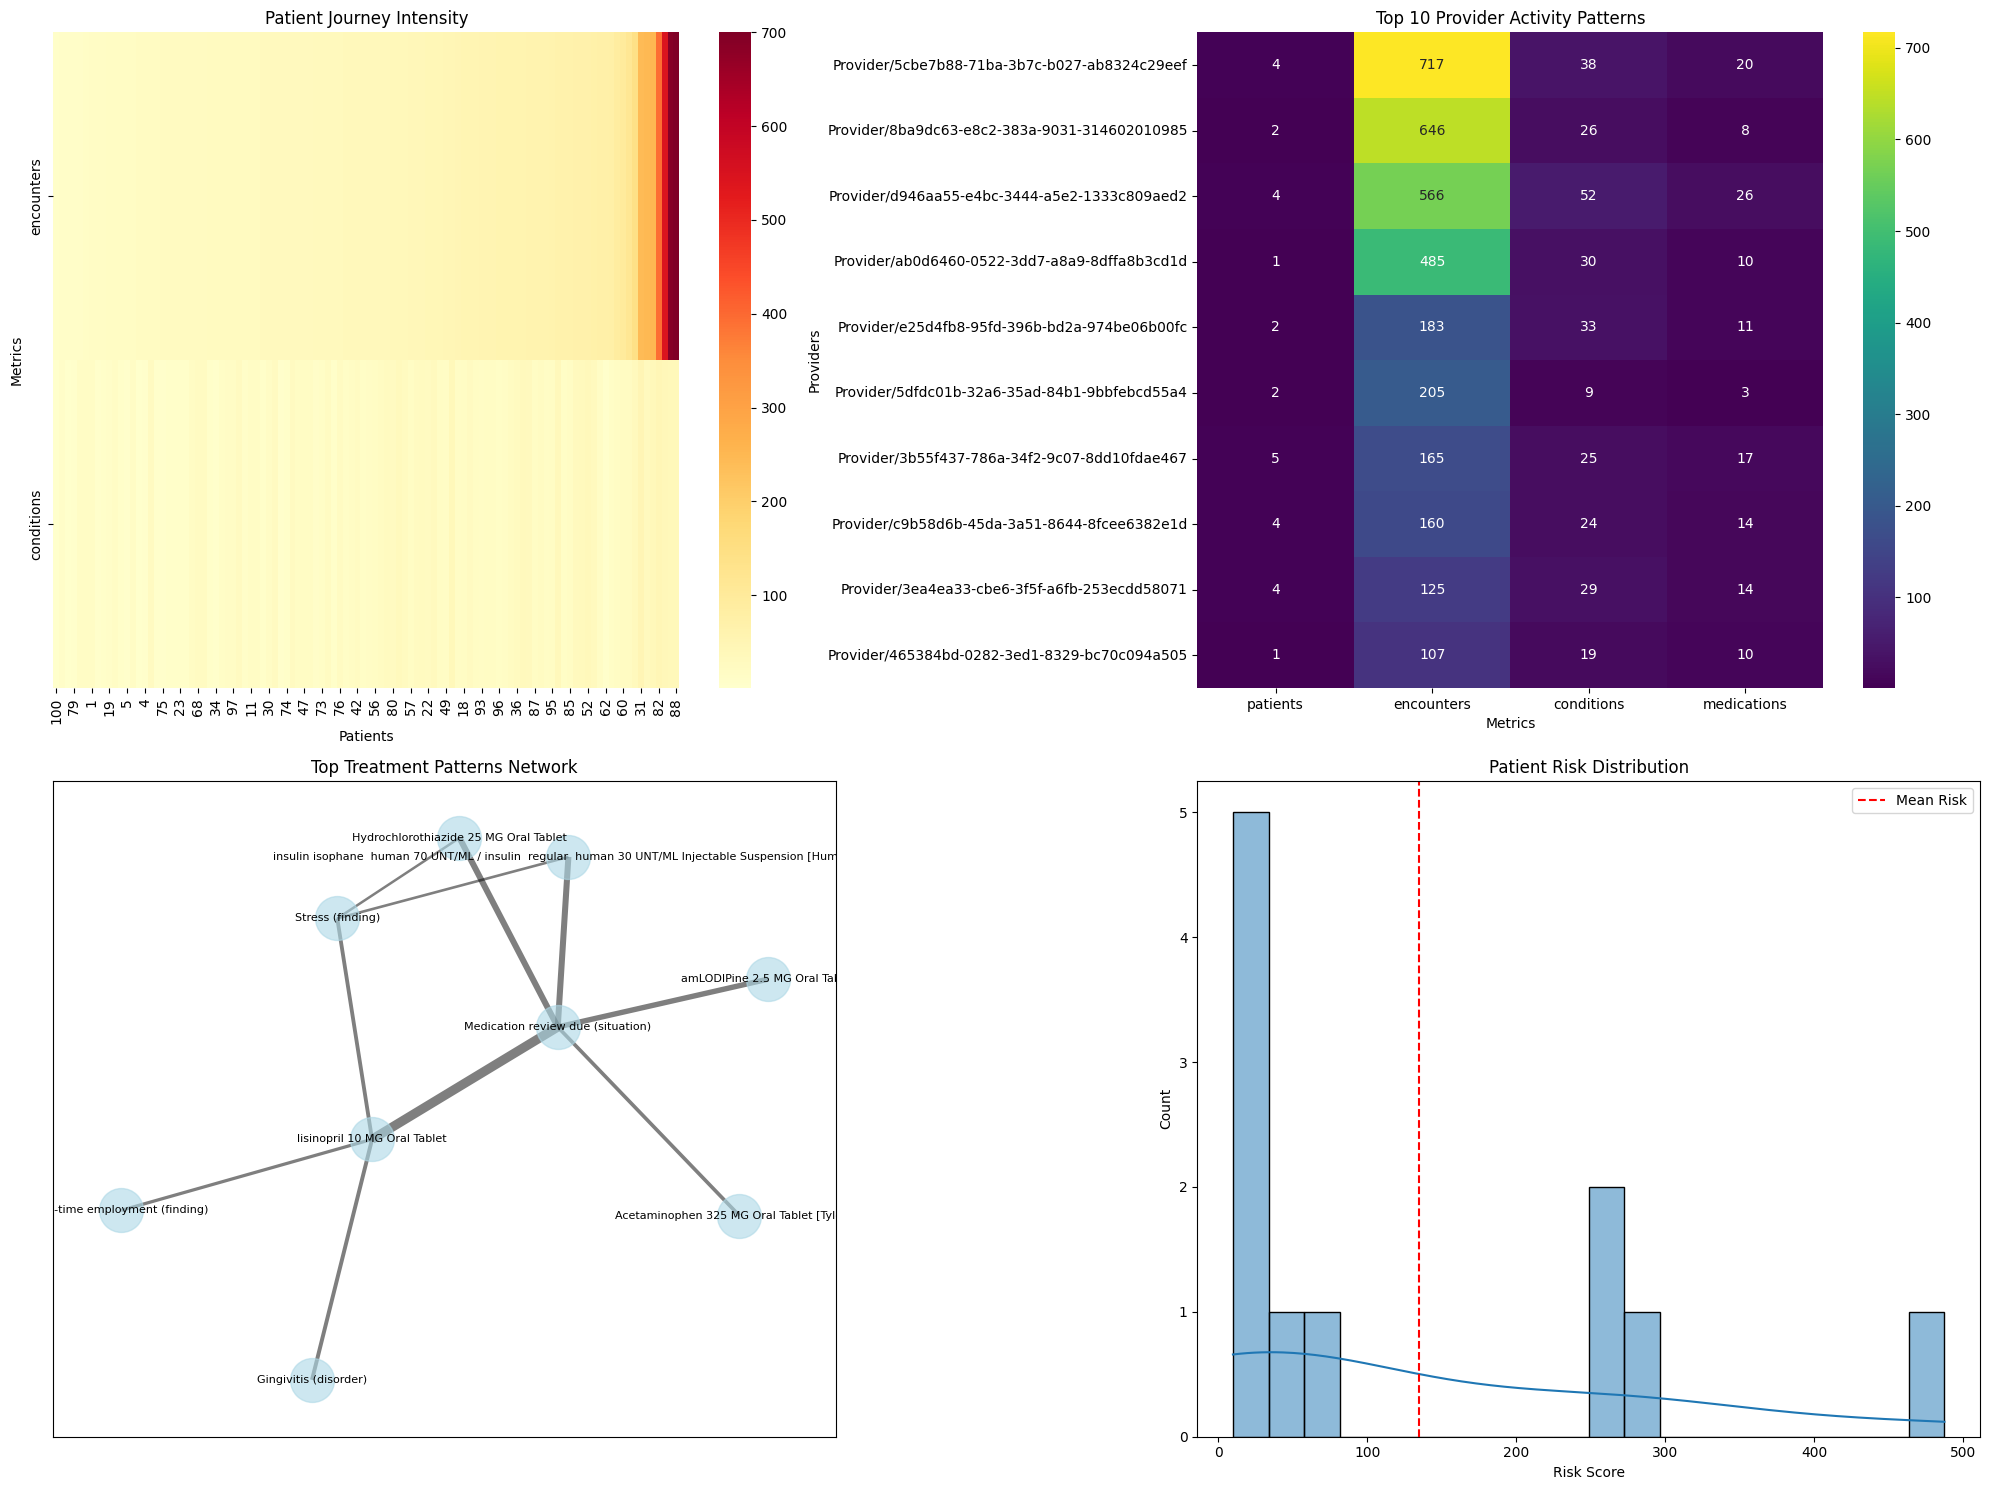

Visualizations saved successfully!


In [19]:
# [Code Cell 7] - Advanced Medical Graph Visualizations
print("\nCreating medical graph visualizations...")

def visualize_medical_patterns(G, analysis_results):
    try:
        plt.figure(figsize=(20, 15))

        # 1. Patient Journey Heatmap
        plt.subplot(2, 2, 1)
        patient_data = pd.DataFrame({
            'encounters': list(analysis_results['encounters_per_patient'].values()),
            'conditions': list(analysis_results['conditions_per_patient'].values())
        })
        patient_data = patient_data.sort_values(['encounters', 'conditions'])
        sns.heatmap(patient_data.T, cmap='YlOrRd')
        plt.title('Patient Journey Intensity')
        plt.xlabel('Patients')
        plt.ylabel('Metrics')

        # 2. Provider Activity Patterns (Updated)
        plt.subplot(2, 2, 2)
        provider_data = pd.DataFrame.from_dict(
            {k: {
                'patients': v['patient_count'],
                'encounters': v['encounter_count'],
                'conditions': v['condition_count'],
                'medications': v['medication_count']
            }
            for k, v in analysis_results['provider_metrics'].items()
        }).T

        # Sort by total activity
        provider_data['total'] = provider_data.sum(axis=1)
        provider_data = provider_data.sort_values('total', ascending=False).head(10)
        provider_data = provider_data.drop('total', axis=1)

        sns.heatmap(provider_data, cmap='viridis', annot=True, fmt='g')
        plt.title('Top 10 Provider Activity Patterns')
        plt.xlabel('Metrics')
        plt.ylabel('Providers')

        # 3. Treatment Network Graph
        plt.subplot(2, 2, 3)
        treatment_pairs = analysis_results['treatment_patterns']
        top_pairs = dict(sorted(treatment_pairs.items(), key=lambda x: x[1], reverse=True)[:10])

        treatment_graph = nx.Graph()
        for (cond, med), count in top_pairs.items():
            treatment_graph.add_edge(cond, med, weight=count)

        pos = nx.spring_layout(treatment_graph, k=1)
        nx.draw_networkx_nodes(treatment_graph, pos,
                             node_color='lightblue',
                             node_size=1000,
                             alpha=0.6)
        nx.draw_networkx_edges(treatment_graph, pos,
                             width=[treatment_graph[u][v]['weight']/50 for u,v in treatment_graph.edges()],
                             alpha=0.5)
        nx.draw_networkx_labels(treatment_graph, pos, font_size=8)
        plt.title('Top Treatment Patterns Network')

        # 4. Risk Distribution (Updated)
        plt.subplot(2, 2, 4)
        risk_scores = list(analysis_results['risk_scores'].values())
        sns.histplot(data=risk_scores, bins=20, kde=True)
        plt.axvline(np.mean(risk_scores), color='r', linestyle='--', label='Mean Risk')
        plt.title('Patient Risk Distribution')
        plt.xlabel('Risk Score')
        plt.ylabel('Count')
        plt.legend()

        plt.tight_layout()
        plt.savefig('processed_data/medical_patterns.png')
        plt.show()
        plt.close()
        print("Visualizations saved successfully!")

    except Exception as e:
        print(f"Error creating visualizations: {str(e)}")
        plt.close()

# Create visualizations
visualize_medical_patterns(G, analysis_results)


Visualizing overall graph structure...


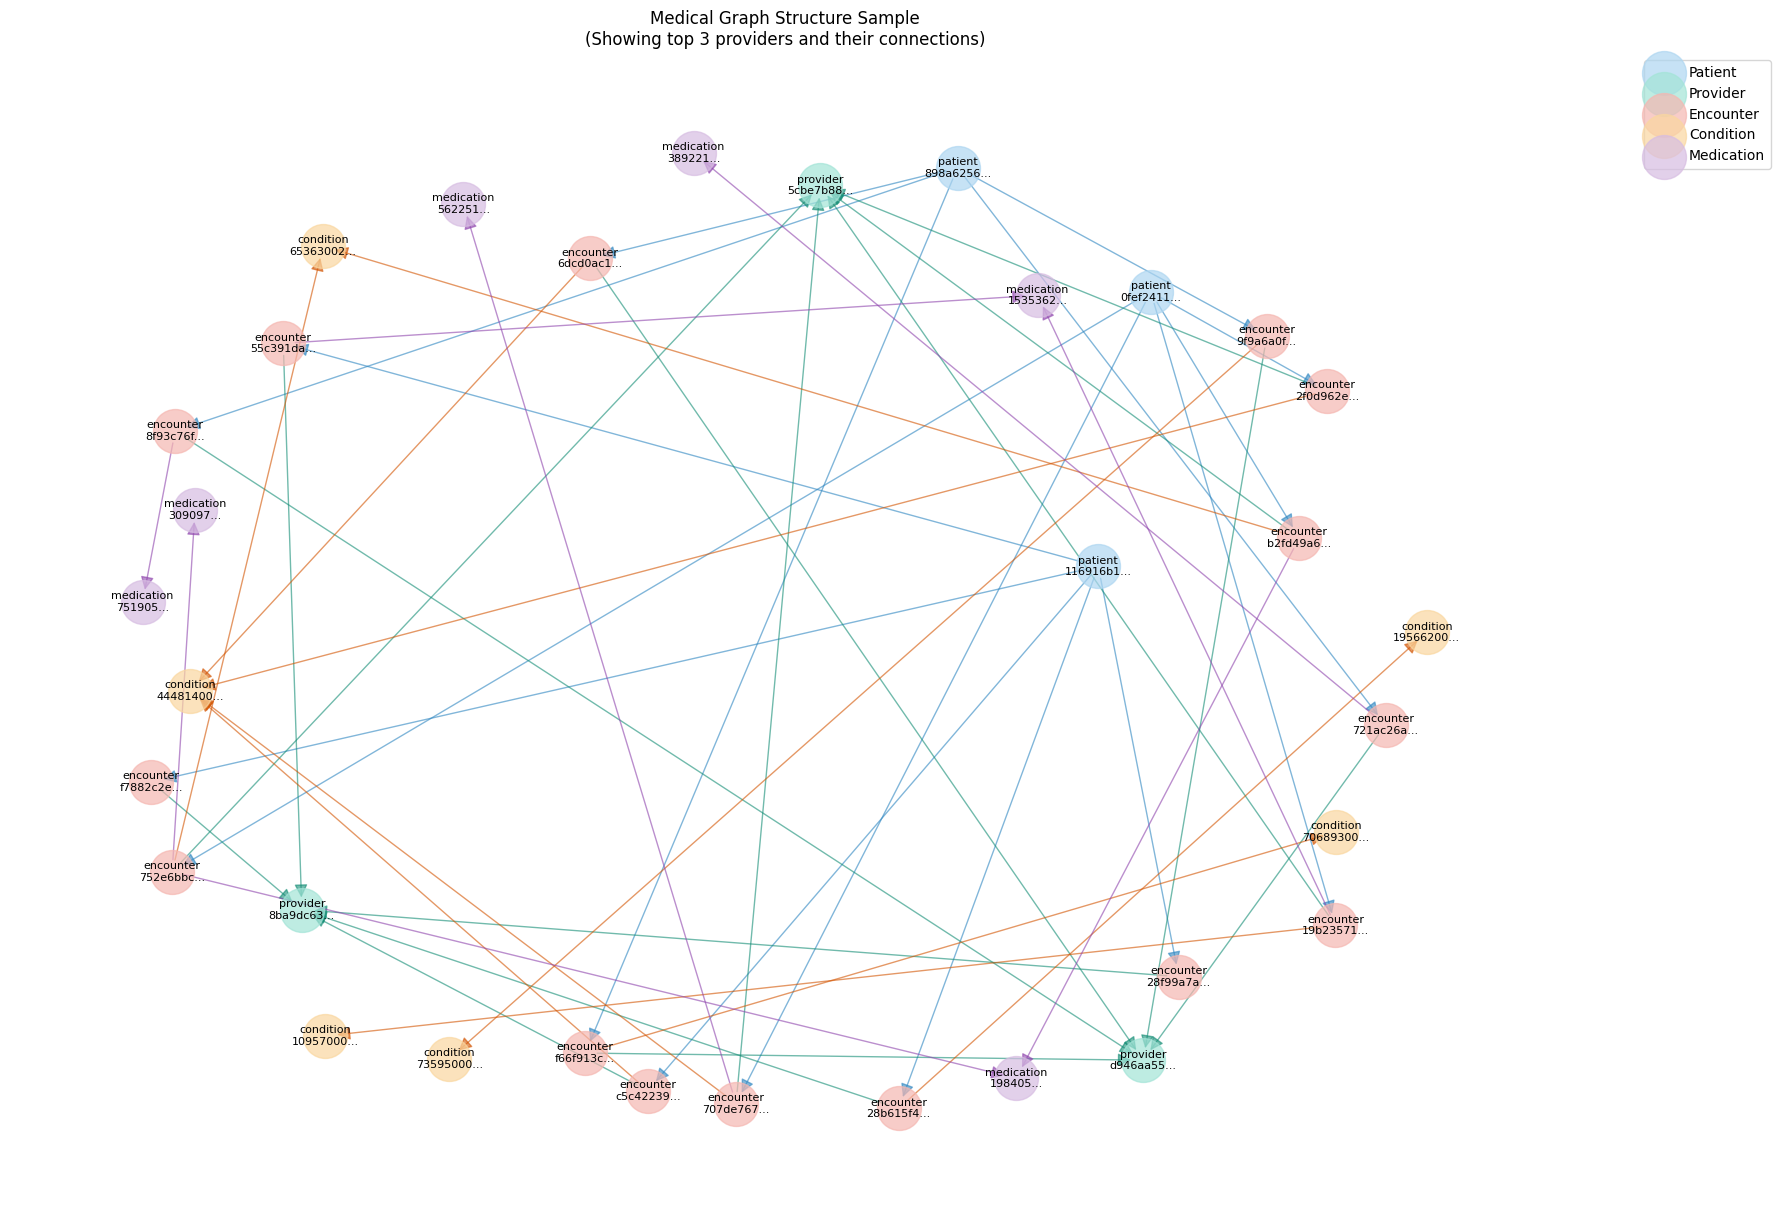

Graph structure visualization saved and displayed!


In [20]:
# [Code Cell 8] - Graph Structure Visualization
print("\nVisualizing overall graph structure...")

def visualize_graph_structure(G):
    try:
        plt.figure(figsize=(20, 15))

        # Create a smaller subgraph for visualization
        # Take the top 3 providers and their related nodes
        provider_metrics = {
            provider: {
                'encounter_count': len([n for n in G.predecessors(provider)
                                     if G.nodes[n]['type'] == 'encounter'])
            }
            for provider in [n for n, d in G.nodes(data=True) if d['type'] == 'provider']
        }

        top_providers = sorted(provider_metrics.items(),
                             key=lambda x: x[1]['encounter_count'],
                             reverse=True)[:3]

        sample_nodes = []
        for provider, _ in top_providers:
            sample_nodes.append(provider)
            # Add connected encounters
            encounters = [n for n in G.predecessors(provider) if G.nodes[n]['type'] == 'encounter'][:5]
            sample_nodes.extend(encounters)

            for enc in encounters:
                # Add patients
                patients = [n for n in G.predecessors(enc) if G.nodes[n]['type'] == 'patient'][:2]
                sample_nodes.extend(patients)
                # Add conditions and medications
                conditions = [n for n in G.successors(enc) if G.nodes[n]['type'] == 'condition'][:2]
                medications = [n for n in G.successors(enc) if G.nodes[n]['type'] == 'medication'][:2]
                sample_nodes.extend(conditions)
                sample_nodes.extend(medications)

        # Create subgraph
        subgraph = G.subgraph(sample_nodes)

        # Node colors and sizes
        node_colors = {
            'patient': '#AED6F1',  # Light blue
            'provider': '#A3E4D7',  # Light green
            'encounter': '#F5B7B1',  # Light red
            'condition': '#FAD7A0',  # Light orange
            'medication': '#D7BDE2'  # Light purple
        }

        # Position nodes using spring layout
        pos = nx.spring_layout(subgraph, k=2, iterations=50)

        # Draw nodes by type
        for node_type, color in node_colors.items():
            nodes = [n for n, d in subgraph.nodes(data=True) if d['type'] == node_type]
            nx.draw_networkx_nodes(subgraph, pos,
                                 nodelist=nodes,
                                 node_color=color,
                                 node_size=1000,
                                 alpha=0.7,
                                 label=node_type.capitalize())

        # Draw edges with arrows
        edge_colors = {
            'PATIENT_ENCOUNTER': '#2E86C1',
            'ENCOUNTER_PROVIDER': '#138D75',
            'ENCOUNTER_CONDITION': '#D35400',
            'ENCOUNTER_MEDICATION': '#8E44AD'
        }

        for edge_type, color in edge_colors.items():
            edges = [(u, v) for u, v, d in subgraph.edges(data=True)
                    if d.get('relationship_type') == edge_type]
            nx.draw_networkx_edges(subgraph, pos,
                                 edgelist=edges,
                                 edge_color=color,
                                 width=1,
                                 alpha=0.6,
                                 arrows=True,
                                 arrowsize=20,
                                 label=edge_type)

        # Add labels
        labels = {
            node: f"{data['type']}\n{node.split('/')[-1][:8]}..."
            for node, data in subgraph.nodes(data=True)
        }
        nx.draw_networkx_labels(subgraph, pos, labels, font_size=8)

        plt.title('Medical Graph Structure Sample\n(Showing top 3 providers and their connections)')
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.axis('off')

        # Save and show
        plt.savefig('processed_data/graph_structure.png', bbox_inches='tight')
        plt.show()
        plt.close()
        print("Graph structure visualization saved and displayed!")

    except Exception as e:
        print(f"Error visualizing graph structure: {str(e)}")
        plt.close()

# Create graph structure visualization
visualize_graph_structure(G)

# STEP 3

In [21]:
# Debug problematic nodes
print("Debugging problematic nodes...")

problematic_nodes = [
    "Observation/QALY",
    "Observation/DALY",
    "Observation/QOLS",
    "Allergy/419199007",
    "Allergy/256277009",
    "Allergy/782576004",
    "Allergy/288328004",
    "Allergy/260147004"
]

print("\nNode Data Analysis:")
for node in problematic_nodes:
    print(f"\nNode: {node}")
    print("Raw data:")
    print(G.nodes[node])
    print("Data types:")
    for key, value in G.nodes[node].items():
        print(f"- {key}: {type(value)}")

# Check if there are any special characters or encoding issues
import json
print("\nJSON Serialization Test:")
for node in problematic_nodes[:2]:  # Test first two nodes
    try:
        json_str = json.dumps(G.nodes[node])
        print(f"\n{node} - JSON serializable:")
        print(json_str)
    except Exception as e:
        print(f"\n{node} - JSON error:")
        print(f"Error: {str(e)}")

# Check ArangoDB document requirements
print("\nArangoDB Key Format Test:")
for node in problematic_nodes:
    key = str(node).replace('/', '_')
    print(f"\nOriginal: {node}")
    print(f"Modified key: {key}")
    print(f"Contains only alphanumeric and _: {key.replace('_','').isalnum()}")

Debugging problematic nodes...

Node Data Analysis:

Node: Observation/QALY
Raw data:
{'type': 'observation', 'CODE': 'QALY', 'DESCRIPTION': 'QALY', 'TYPE': 'numeric', 'CATEGORY': nan}
Data types:
- type: <class 'str'>
- CODE: <class 'str'>
- DESCRIPTION: <class 'str'>
- TYPE: <class 'str'>
- CATEGORY: <class 'float'>

Node: Observation/DALY
Raw data:
{'type': 'observation', 'CODE': 'DALY', 'DESCRIPTION': 'DALY', 'TYPE': 'numeric', 'CATEGORY': nan}
Data types:
- type: <class 'str'>
- CODE: <class 'str'>
- DESCRIPTION: <class 'str'>
- TYPE: <class 'str'>
- CATEGORY: <class 'float'>

Node: Observation/QOLS
Raw data:
{'type': 'observation', 'CODE': 'QOLS', 'DESCRIPTION': 'QOLS', 'TYPE': 'numeric', 'CATEGORY': nan}
Data types:
- type: <class 'str'>
- CODE: <class 'str'>
- DESCRIPTION: <class 'str'>
- TYPE: <class 'str'>
- CATEGORY: <class 'float'>

Node: Allergy/419199007
Raw data:
{'type': 'allergy', 'CODE': 419199007, 'DESCRIPTION': 'Allergy to substance (finding)', 'TYPE': 'allergy', 'S

In [22]:
# 1. Create ArangoDB graph from NetworkX

# First, let's convert Timestamps in our NetworkX graph
def convert_timestamps(G):
    print("Converting timestamps to string format...")
    for node, data in G.nodes(data=True):
        for key, value in data.items():
            if isinstance(value, pd.Timestamp):
                data[key] = value.strftime('%Y-%m-%d %H:%M:%S')
    return G

# Convert timestamps
G = convert_timestamps(G)

Converting timestamps to string format...


# Complete graph persistence with direct ArangoDB client
print("Creating medical graph in ArangoDB...")

# Helper function to clean data
def clean_data(data):
    cleaned = {}
    for key, value in data.items():
        # Remove asterisks from keys
        clean_key = key.replace('*', '_')
        # Convert NaN to None
        if pd.isna(value):
            cleaned[clean_key] = None
        # Convert integers to strings
        elif isinstance(value, int):
            cleaned[clean_key] = str(value)
        # Handle other types
        else:
            cleaned[clean_key] = value
    return cleaned

# 1. Clean up existing data
if db.has_graph('MedGraph'):
    db.delete_graph('MedGraph')
for collection in ['MedGraph_node', 'MedGraph_node_to_MedGraph_node']:
    if db.has_collection(collection):
        db.delete_collection(collection)

# 2. Create collections
nodes = db.create_collection('MedGraph_node')
edges = db.create_collection('MedGraph_node_to_MedGraph_node', edge=True)

# 3. Create graph definition
graph = db.create_graph('MedGraph')
graph.create_edge_definition(
    edge_collection='MedGraph_node_to_MedGraph_node',
    from_vertex_collections=['MedGraph_node'],
    to_vertex_collections=['MedGraph_node']
)

# 4. Insert nodes with cleaned data
print("\nInserting nodes...")
node_count = 0
node_keys = {}  # Store mapping of original keys to cleaned keys

for node, data in G.nodes(data=True):
    try:
        # Clean the data
        cleaned_data = clean_data(data)
        # Create proper key
        clean_key = str(node).replace('/', '_').replace('*', '_')
        doc = {
            '_key': clean_key,
            'original_id': node,  # Keep original ID for reference
            **cleaned_data
        }
        nodes.insert(doc)
        node_keys[node] = clean_key
        node_count += 1
        if node_count % 1000 == 0:
            print(f"Inserted {node_count} nodes")
    except Exception as e:
        print(f"Error inserting node {node}: {str(e)}")

# 5. Insert edges with cleaned references
print("\nInserting edges...")
edge_count = 0
for source, target, data in G.edges(data=True):
    try:
        # Clean edge data
        cleaned_data = clean_data(data)
        doc = {
            '_from': f"MedGraph_node/{node_keys[source]}",
            '_to': f"MedGraph_node/{node_keys[target]}",
            **cleaned_data
        }
        edges.insert(doc)
        edge_count += 1
        if edge_count % 10000 == 0:
            print(f"Inserted {edge_count} edges")
    except Exception as e:
        print(f"Error inserting edge {source}->{target}: {str(e)}")


In [23]:
# Cell 1: Import dependencies
import pandas as pd
import numpy as np
from concurrent.futures import ThreadPoolExecutor
import math

# Cell 2: Helper functions for data cleaning
def preprocess_value(value):
    """Preprocess individual values to ensure consistent types"""
    if pd.isna(value):
        return None
    elif isinstance(value, (int, float)):
        return str(value)
    elif isinstance(value, (list, dict)):
        return str(value)
    return value

def clean_data_cpu(data_dict):
    """Clean data on CPU"""
    cleaned = {}
    for key, value in data_dict.items():
        clean_key = key.replace('*', '_')
        cleaned[clean_key] = preprocess_value(value)
    return cleaned

# Cell 3: Clean up existing data
print("Creating medical graph in ArangoDB...")
if db.has_graph('MedGraph'):
    db.delete_graph('MedGraph')
for collection in ['MedGraph_node', 'MedGraph_node_to_MedGraph_node']:
    if db.has_collection(collection):
        db.delete_collection(collection)

# Cell 4: Create collections and graph
nodes = db.create_collection('MedGraph_node')
edges = db.create_collection('MedGraph_node_to_MedGraph_node', edge=True)

graph = db.create_graph('MedGraph')
graph.create_edge_definition(
    edge_collection='MedGraph_node_to_MedGraph_node',
    from_vertex_collections=['MedGraph_node'],
    to_vertex_collections=['MedGraph_node']
)

# Cell 5: Prepare node data
print("\nPreparing node data...")
node_keys = {}
node_data = []
batch_size = 5000

for node, data in G.nodes(data=True):
    clean_key = str(node).replace('/', '_').replace('*', '_')
    node_data.append({
        **clean_data_cpu(data),
        'original_id': node,
        '_key': clean_key
    })
    node_keys[node] = clean_key

total_nodes = len(node_data)
num_batches = math.ceil(total_nodes / batch_size)

# Cell 6: Process and insert nodes
print("\nInserting nodes...")
def process_node_batch(batch_idx):
    start_idx = batch_idx * batch_size
    end_idx = min(start_idx + batch_size, total_nodes)
    batch = node_data[start_idx:end_idx]

    try:
        nodes.insert_many(batch)
        print(f"Inserted batch {batch_idx + 1}/{num_batches} of nodes")
    except Exception as e:
        print(f"Error inserting node batch {batch_idx}: {str(e)}")
        # Fallback to single insertions
        for doc in batch:
            try:
                nodes.insert(doc)
            except Exception as e2:
                print(f"Error inserting individual node: {str(e2)}")

with ThreadPoolExecutor(max_workers=4) as executor:
    list(executor.map(process_node_batch, range(num_batches)))

# Cell 7: Prepare edge data
print("\nPreparing edge data...")
edge_data = []

for source, target, data in G.edges(data=True):
    edge_data.append({
        **clean_data_cpu(data),
        '_from': f"MedGraph_node/{node_keys[source]}",
        '_to': f"MedGraph_node/{node_keys[target]}"
    })

total_edges = len(edge_data)
num_edge_batches = math.ceil(total_edges / batch_size)

# Cell 8: Process and insert edges
print("\nInserting edges...")
def process_edge_batch(batch_idx):
    start_idx = batch_idx * batch_size
    end_idx = min(start_idx + batch_size, total_edges)
    batch = edge_data[start_idx:end_idx]

    try:
        edges.insert_many(batch)
        print(f"Inserted batch {batch_idx + 1}/{num_edge_batches} of edges")
    except Exception as e:
        print(f"Error inserting edge batch {batch_idx}: {str(e)}")
        # Fallback to single insertions
        for doc in batch:
            try:
                edges.insert(doc)
            except Exception as e2:
                print(f"Error inserting individual edge: {str(e2)}")

with ThreadPoolExecutor(max_workers=4) as executor:
    list(executor.map(process_edge_batch, range(num_edge_batches)))

# Cell 9: Verify persistence
print("\nVerifying graph persistence:")
actual_nodes = nodes.count()
actual_edges = edges.count()
print(f"Nodes in collection: {actual_nodes}")
print(f"Edges in collection: {actual_edges}")

# Verify counts match expected
if actual_nodes != total_nodes:
    print(f"Warning: Node count mismatch. Expected {total_nodes}, got {actual_nodes}")
if actual_edges != total_edges:
    print(f"Warning: Edge count mismatch. Expected {total_edges}, got {actual_edges}")

# Sample verification
try:
    # Verify a sample of nodes
    cursor = nodes.all()
    sample_node = next(cursor)
    print("\nSample node structure:", list(sample_node.keys()))

    # Verify a sample of edges
    cursor = edges.all()
    sample_edge = next(cursor)
    print("Sample edge structure:", list(sample_edge.keys()))

    # Verify graph connectivity
    if actual_edges > 0:
        aql = db.aql
        query = """
            WITH MedGraph_node, MedGraph_node_to_MedGraph_node
            FOR v, e IN 1..1 ANY @start_vertex MedGraph_node_to_MedGraph_node
            RETURN {vertex: v, edge: e}
        """
        sample_traversal = list(aql.execute(query, bind_vars={'start_vertex': sample_node['_id']}, count=1))
        if sample_traversal:
            print("Graph connectivity verified: Sample traversal successful")
        else:
            print("Warning: Could not verify graph connectivity")

except Exception as e:
    print(f"Warning: Error during verification: {str(e)}")

Creating medical graph in ArangoDB...

Preparing node data...

Inserting nodes...
Inserted batch 1/2 of nodes
Inserted batch 2/2 of nodes

Preparing edge data...

Inserting edges...
Inserted batch 1/25 of edges
Inserted batch 2/25 of edges
Inserted batch 5/25 of edges
Inserted batch 6/25 of edges
Inserted batch 3/25 of edges
Inserted batch 4/25 of edges
Inserted batch 7/25 of edges
Inserted batch 8/25 of edges
Inserted batch 11/25 of edges
Inserted batch 12/25 of edges
Inserted batch 9/25 of edges
Inserted batch 10/25 of edges
Inserted batch 13/25 of edges
Inserted batch 14/25 of edges
Inserted batch 17/25 of edges
Inserted batch 15/25 of edges
Inserted batch 16/25 of edges
Inserted batch 19/25 of edges
Inserted batch 18/25 of edges
Inserted batch 20/25 of edges
Inserted batch 21/25 of edges
Inserted batch 22/25 of edges
Inserted batch 25/25 of edges
Inserted batch 23/25 of edges
Inserted batch 24/25 of edges

Verifying graph persistence:
Nodes in collection: 8776
Edges in collection: 

In [24]:
# 6. Verify persistence
print("\nVerifying graph persistence:")
print(f"Nodes in collection: {nodes.count()}")
print(f"Edges in collection: {edges.count()}")


Verifying graph persistence:
Nodes in collection: 8776
Edges in collection: 122201


In [25]:
# 7. Test complex query
print("\nTesting graph queries...")
queries = [
    """
    // Provider count
    FOR v IN MedGraph_node
        FILTER v.type == 'provider'
        LIMIT 5
        RETURN v.NAME
    """,
    """
    // Node type distribution
    FOR v IN MedGraph_node
        COLLECT type = v.type WITH COUNT INTO count
        RETURN {type: type, count: count}
    """
]

for i, query in enumerate(queries, 1):
    print(f"\nQuery {i} results:")
    result = db.aql.execute(query)
    for item in result:
        print(f"- {item}")


Testing graph queries...

Query 1 results:
- Ted955 Reilly981
- Gustavo235 Armstrong51
- Isabela97 Solorio55
- Jules135 Emard19
- Kip442 Krajcik437

Query 2 results:
- {'type': 'allergy', 'count': 17}
- {'type': 'careplan', 'count': 329}
- {'type': 'condition', 'count': 175}
- {'type': 'encounter', 'count': 7049}
- {'type': 'medication', 'count': 116}
- {'type': 'observation', 'count': 215}
- {'type': 'organization', 'count': 272}
- {'type': 'patient', 'count': 106}
- {'type': 'procedure', 'count': 225}
- {'type': 'provider', 'count': 272}


In [26]:
G_adb = nxadb.Graph(name="MedGraph", db=db)

print(G_adb)

[08:29:44 +0000] [INFO]: Graph 'MedGraph' exists.
INFO:nx_arangodb:Graph 'MedGraph' exists.
[08:29:44 +0000] [INFO]: Default node type set to 'MedGraph_node'
INFO:nx_arangodb:Default node type set to 'MedGraph_node'


Graph named 'MedGraph' with 8776 nodes and 122201 edges


In [27]:
from langchain_together import ChatTogether